In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

from msfm.grid_pipeline import GridPipeline
from msfm.utils import files, scales

In [3]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)
params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
data_vec_pix, patches_pix_dict, _, _ = files.load_pixel_file(conf)
mask = hp.ring2nest(n_side, patches_pix_dict["metacal"][0][0])
anti_mask = np.setdiff1d(np.arange(n_pix), mask)
f_sky = n_pix/(n_pix - len(anti_mask))

24-10-08 00:16:44     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [4]:
i_z = 7

# hard cut from (white_noise_full_sky.ipynb)
l_max = 509

# soft cut (white_noise_full_sky.ipynb)

# 1% noise
theta_fwhm = 34.1
noise_sigma = 1.5098e-01

# # 10 % noise
# theta_fwhm = 0.707 *  34.1
# noise_sigma = 4.6794e-01

In [5]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

rot=(90, -30, 0)

# load example map 

In [6]:
with_lensing = True
with_clustering = True

grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
)

data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal

grid_dset = grid_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
)

for dv, cl, cosmo, index in grid_dset.take(1):
    pass

24-10-08 00:16:45     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-08 00:16:45     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-08 00:16:47 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-10-08 00:16:47 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-10-08 00:16:47 grid_pipelin INF   Including noise_indices = [0] 
24-10-08 00:16:47 grid_pipelin INF   Interleaving with n_readers = 1 
dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'cl'])
24-10-08 00:16:49 grid_pipelin INF   Batching into 1 elements locally 
24-10-08 00:16:49 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

24-10-08 00:16:57     files.py WAR   Loading the default config from /global/u2/a/athomsen/multiprobe-simulation-forward-model/configs/config.yaml 


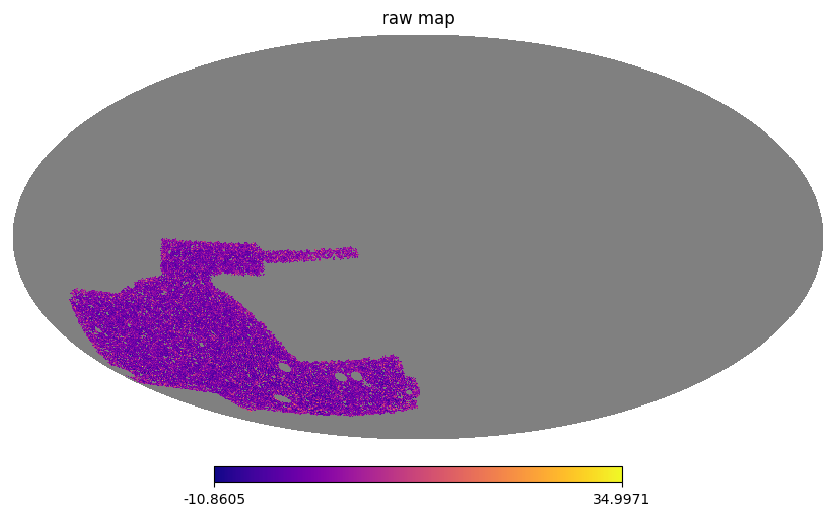

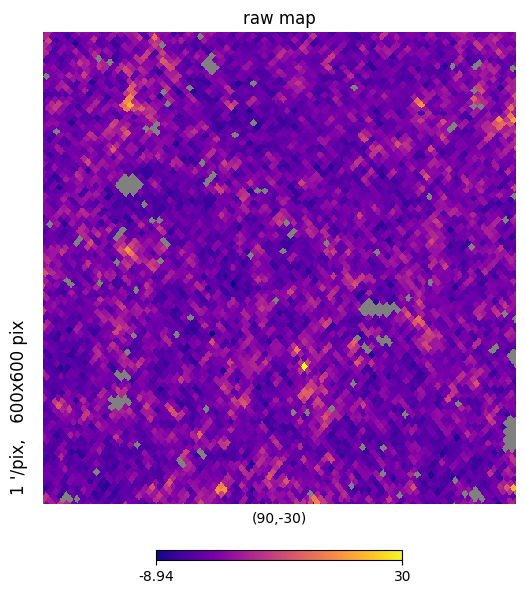

In [7]:
raw_map = np.zeros(n_pix)
raw_map[data_vec_pix] = dv[0,:,i_z]

vmin = raw_map.min()
vmax = raw_map.max()

def plot_map(full_sky_map, title):    
    masked_map = full_sky_map.copy()
    masked_map[anti_mask] = hp.UNSEEN
    
    hp.mollview(
        masked_map, 
        title=title, 
        nest=True, 
        # min=vmin, 
        # max=vmax, 
        cmap="plasma"
    )
    
    hp.gnomview(
        masked_map, 
        title=title, 
        nest=True, 
        rot=rot, 
        reso=reso, 
        xsize=x_pix, 
        ysize=y_pix, 
        # min=vmin, 
        # max=vmax, 
        cmap="plasma"
    )

raw_map, raw_alms = scales.map_to_smoothed_map(raw_map, n_side, nest=True, hard_cut=True)
plot_map(raw_map, "raw map")

# hard l_max cut

24-10-08 00:16:59     files.py WAR   Loading the default config from /global/u2/a/athomsen/multiprobe-simulation-forward-model/configs/config.yaml 


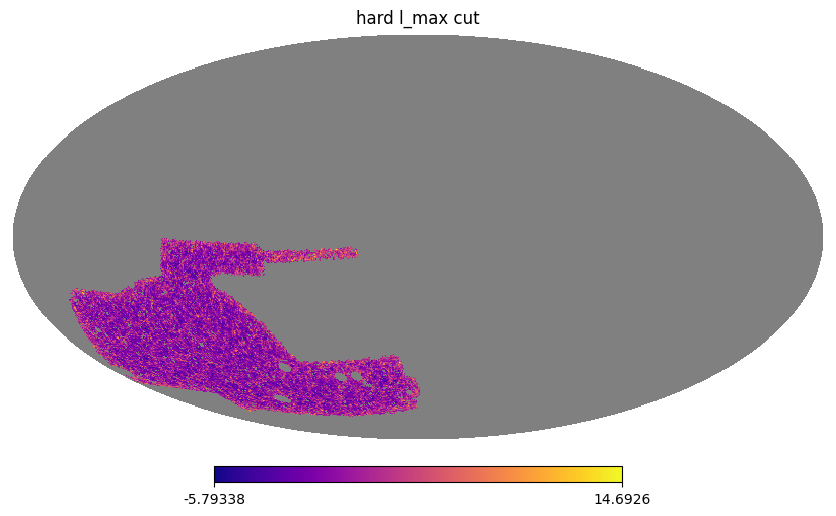

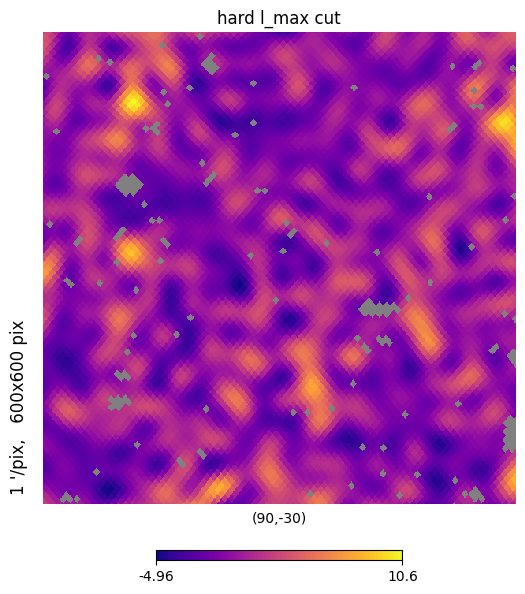

In [8]:
hard_map, hard_alms = scales.map_to_smoothed_map(raw_map, n_side, l_max=l_max, nest=True, hard_cut=True)

plot_map(hard_map, "hard l_max cut")

# soft l_min cut

24-10-08 00:17:01     files.py WAR   Loading the default config from /global/u2/a/athomsen/multiprobe-simulation-forward-model/configs/config.yaml 


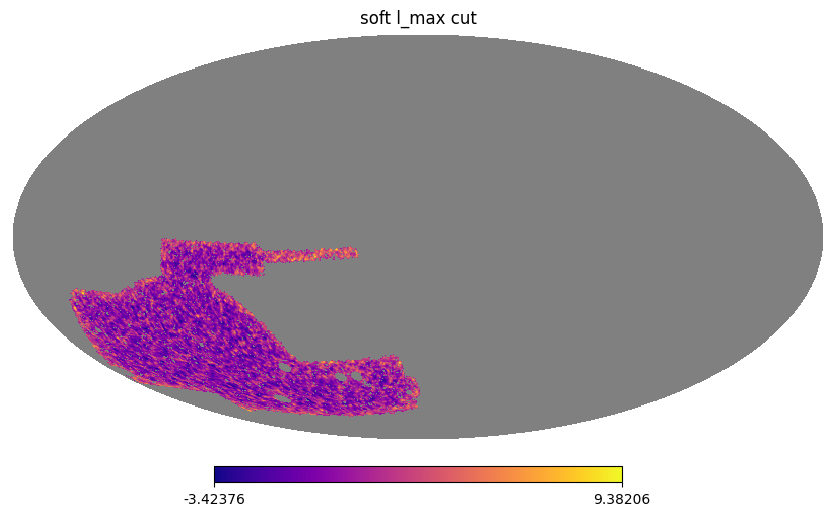

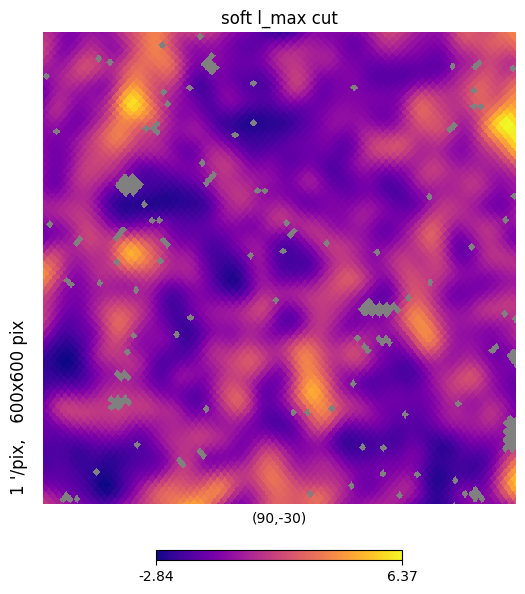

In [9]:
soft_map, soft_alms = scales.map_to_smoothed_map(raw_map, n_side, theta_fwhm=theta_fwhm, nest=True, hard_cut=False)

plot_map(soft_map, "soft l_max cut")

24-10-08 00:17:02     files.py WAR   Loading the default config from /global/u2/a/athomsen/multiprobe-simulation-forward-model/configs/config.yaml 


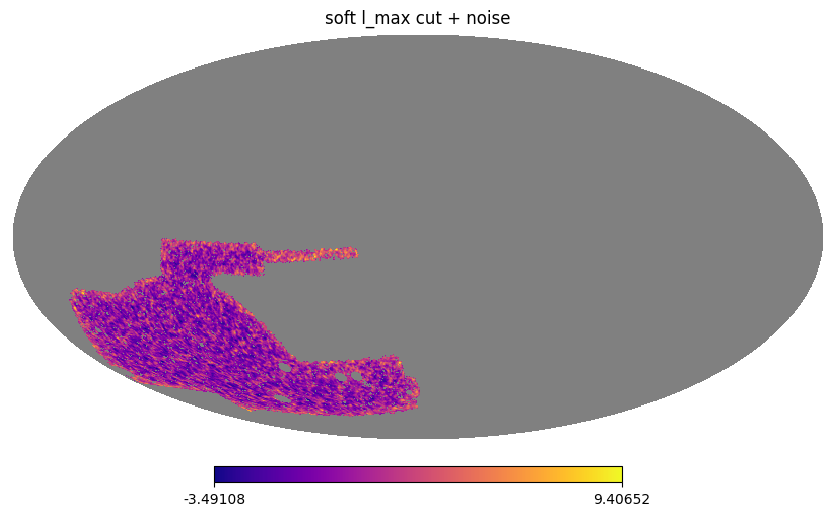

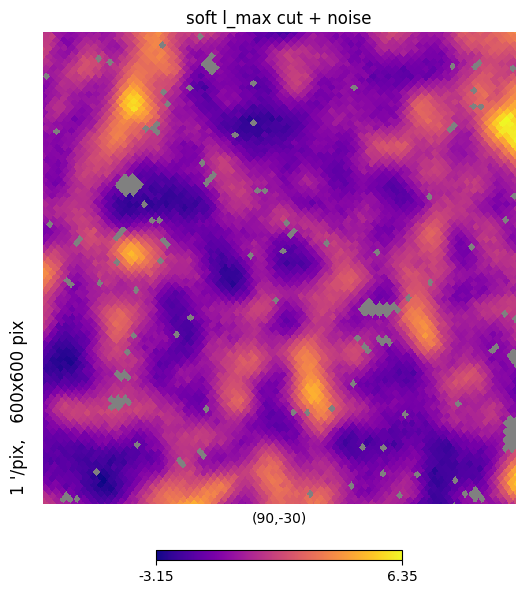

In [10]:
# noisy_map = np.zeros_like(soft_map)
# noisy_map[data_vec_pix] = soft_map[data_vec_pix] + np.random.normal(scale=noise_sigma, size=data_vec_pix.shape[0])
# noisy_map = soft_map + np.random.normal(scale=noise_sigma, size=n_pix)

noisy_map = soft_map.copy()
noisy_map[data_vec_pix] += np.random.normal(scale=noise_sigma, size=data_vec_pix.shape[0])
# noisy_map[data_vec_pix] += np.sqrt(f_sky) * np.random.normal(scale=noise_sigma, size=data_vec_pix.shape[0])
# noisy_map += np.random.normal(scale=noise_sigma, size=n_pix)
# noisy_map[data_vec_pix] += np.random.normal(scale=np.sqrt(noise_sigma), size=data_vec_pix.shape[0])

_, noisy_alms = scales.map_to_smoothed_map(noisy_map, n_side, nest=True, hard_cut=True)

plot_map(noisy_map, "soft l_max cut + noise")

[Text(0.5, 0, '$\\ell$'), Text(0, 0.5, '$C_\\ell$'), None, (1e-09, 0.1)]

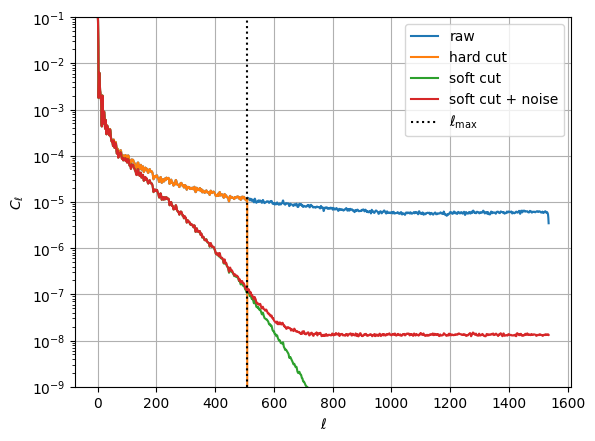

In [11]:
raw_cls = hp.alm2cl(raw_alms)
hard_cls = hp.alm2cl(hard_alms)
soft_cls = hp.alm2cl(soft_alms)
noisy_cls = hp.alm2cl(noisy_alms)

fig, ax = plt.subplots()

ax.plot(raw_cls, label="raw")
ax.plot(hard_cls, label="hard cut")
ax.plot(soft_cls, label="soft cut")
ax.plot(noisy_cls, label="soft cut + noise")
ax.axvline(l_max, label=r"$\ell_{\mathrm{max}}$", color="k", linestyle=":")

ax.grid(True)
ax.legend()
# ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", xlim=(0, l_max+100), ylim=(1e-9, 1e-1))
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-9, 1e-1))


# differences

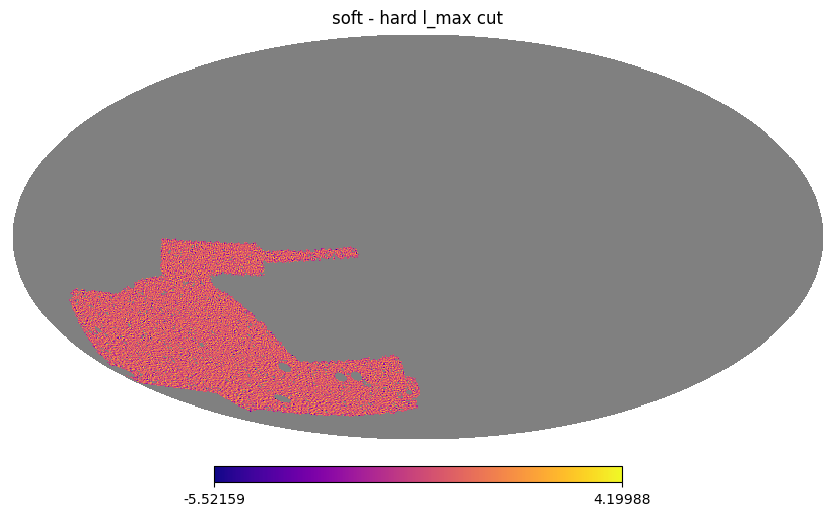

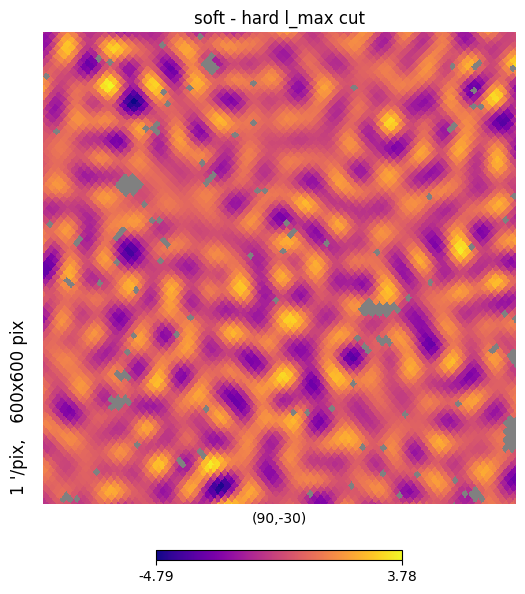

In [12]:
plot_map(soft_map - hard_map, "soft - hard l_max cut")

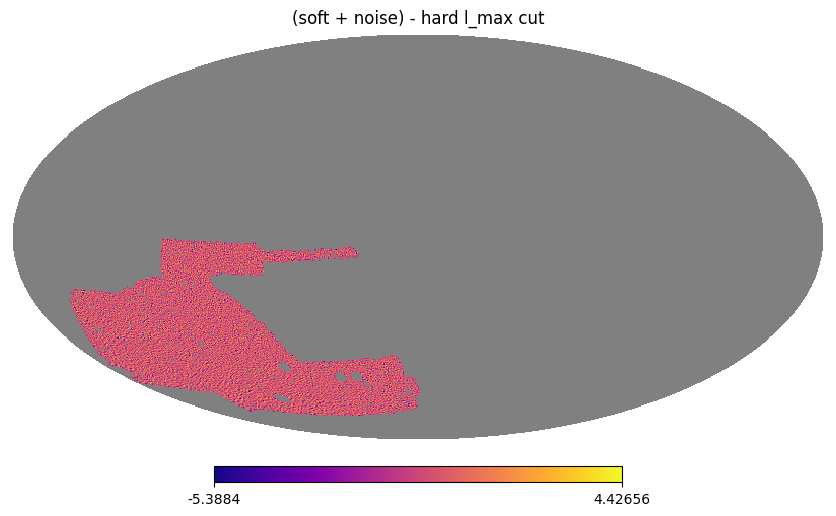

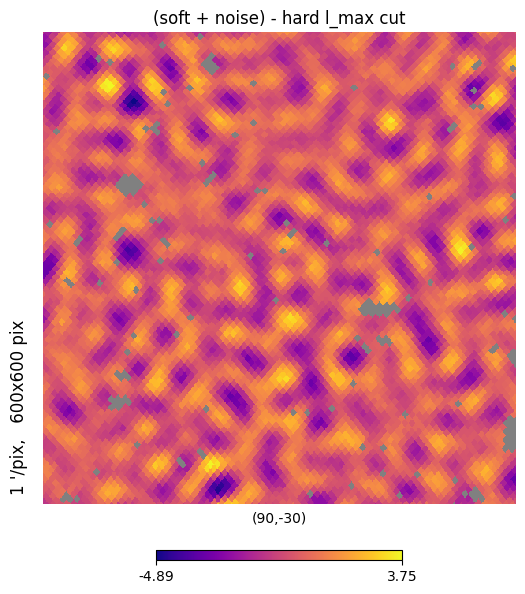

In [13]:
plot_map(noisy_map - hard_map, "(soft + noise) - hard l_max cut")

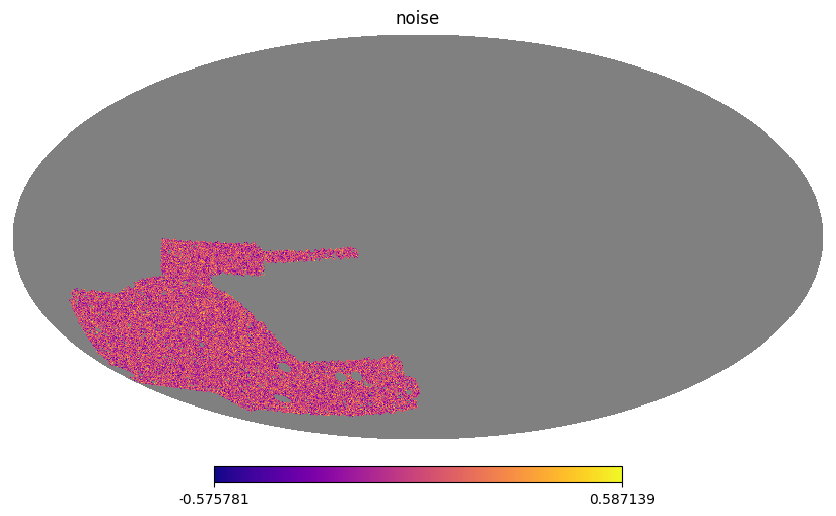

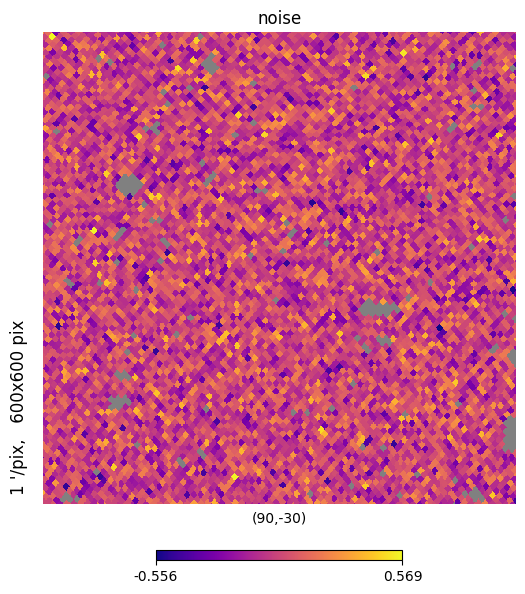

In [14]:
plot_map(noisy_map - soft_map, "noise")